
# Import libraries and packages

In [1]:
import folium
import numpy as np
import pandas as pd
import seaborn as sns

from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Custom modules
# We will use top_20_cities dictionary from here
from openstreetmap import openstreetmap as osm 

# Set parameters

In [2]:
color = 'goldenrod'
sns.set_style("whitegrid")

# Data preparation

## Data import

In [3]:
# Read the data and sort it by total population
data = pd.read_csv('tidy_data.csv', sep=';')
data = data.sort_values(by='Population on the 1st of January, total', ascending=False).reset_index(drop=True)

# Rename the total population column
data.rename(columns={'Population on the 1st of January, total':'total_population'}, inplace=True)

# Replace unicode characters due to rendering issue in Folium
data = data.replace(to_replace={'ü':'u','ö':'o'}, regex=True)

# print(data.shape)
# data.tail()

In [4]:
# Confirm the venue_id is unique
len(data['venue_id'].unique()) == data.shape[0]

True

## Add counts to venue data

In [5]:
# Add ratings count per city to tidy data
data['ratings_count'] = data.rating.notnull().groupby(data['city']).transform('sum').astype(int)

# Add likes_count per city to tidy data
data['likes_count'] = data.likes_cnt.groupby(data['city']).transform('sum').astype(int)

## Create DataFrame to carry counts per city

In [6]:
# Count ratings to distinct dataframe
data_counts = pd.DataFrame(data.rating.notnull().groupby(data['city'], sort=False).sum().astype(int).reset_index())
data_counts = data_counts.merge(data[['city', 'total_population']], on='city') \
                .drop_duplicates() \
                .reset_index(drop=True)
data_counts.columns = ['city', 'ratings_count', 'total_population']
# print(data_counts.shape)
# data_counts

In [7]:
# Count likes to distinct dataframe
likes_counts = pd.DataFrame(data.likes_cnt.groupby(data['city'], sort=False).sum().astype(int).reset_index())
likes_counts.columns = ['city','likes_count']
data_counts = data_counts.merge(likes_counts, on='city')
# data_counts

In [8]:
# Count number of biergartens per city
no_of_biergartens_city = pd.DataFrame(data.groupby('city', sort=False).count().venue_id).reset_index()
no_of_biergartens_city.columns = ['city', 'biergarten_count']

# Join to count data
data_counts = data_counts.merge(no_of_biergartens_city, on='city')
# data_counts

In [9]:
# Count no of biergartens per 100,000 people
data_counts['biergarten_count_100k'] = data_counts['biergarten_count']/data_counts['total_population']*100000
# data_counts

In [10]:
# Add rank variables to dataset
data_counts['biergarten_rank'] = data_counts['biergarten_count'].rank()
data_counts['biergarten_100k_rank'] = data_counts['biergarten_count_100k'].rank()
data_counts

,city,ratings_count,total_population,likes_count,biergarten_count,biergarten_count_100k,biergarten_rank,biergarten_100k_rank
0,Berlin,56,3613495.0,8718,62,1.715790,19.0,8.0
1,Hamburg,12,1830584.0,1123,14,0.764783,11.0,2.0
2,Munchen,59,1456039.0,9408,78,5.356999,20.0,19.0
3,Koln,30,1080394.0,1057,40,3.702353,18.0,16.0
4,Frankfurt am Main,23,746878.0,818,32,4.284502,16.0,17.0
5,Stuttgart,10,632743.0,560,12,1.896505,9.5,10.0
6,Dusseldorf,9,617280.0,481,18,2.916019,13.5,12.0
7,Dortmund,9,586600.0,263,10,1.704739,8.0,7.0
8,Essen,11,583393.0,227,18,3.085399,13.5,14.0
9,Leipzig,17,581980.0,572,33,5.670298,17.0,20.0


# Where can you find most biergartens?

Text(0.5, 34.0, 'No of biergartens per 100,000 people')

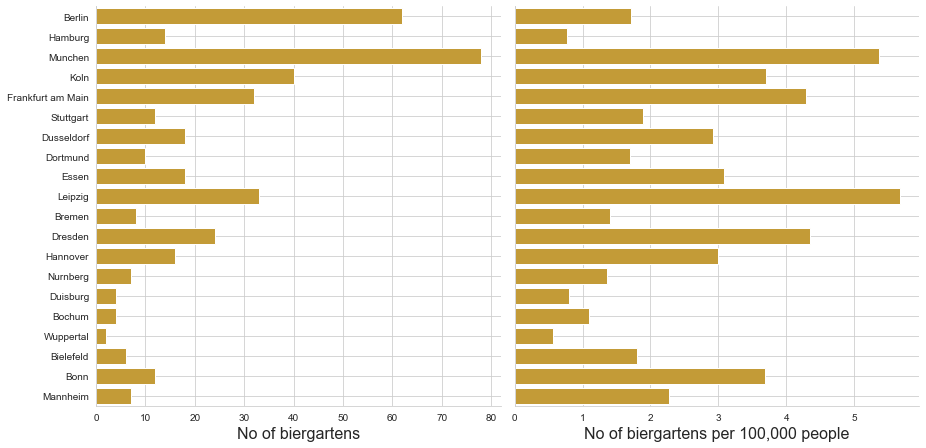

In [11]:
g = sns.PairGrid(data_counts, y_vars=["city"], x_vars=["biergarten_count", "biergarten_count_100k"]
                ,height=6
                ,corner=False
                ,despine=True)
g.map(sns.barplot, color=color, order=data_counts['city'])
g.axes[0,0].grid(True)
g.axes[0,1].grid(True)
g.axes[0,0].set_ylabel('')
g.axes[0,0].set_xlabel('No of biergartens', fontdict={'fontsize':16})
g.axes[0,1].set_xlabel('No of biergartens per 100,000 people', fontdict={'fontsize':16})


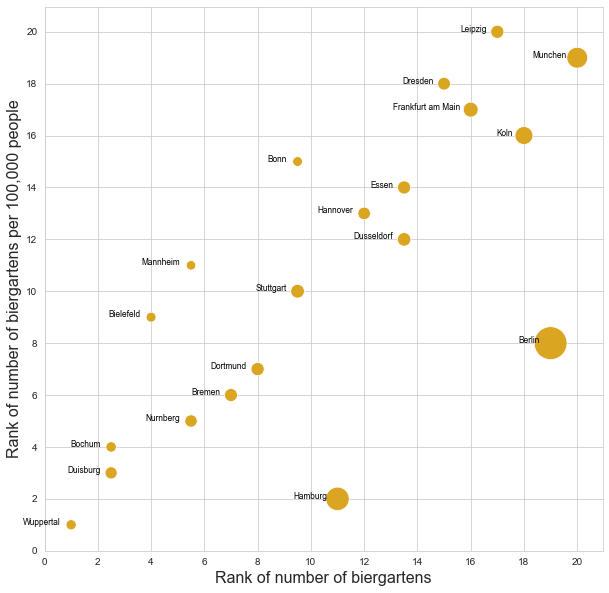

In [12]:
# Plot ranks
plt.figure(figsize=(10,10)) 
ax = sns.scatterplot(data=data_counts
                    , x='biergarten_rank'
                    , y='biergarten_100k_rank'
                    , size='total_population'
                    , sizes=(90,1080) # Population/10,000*3
                    , legend=False
                    , color=color)

for line in range(0, data_counts.shape[0]):
    ax.text(x=data_counts.biergarten_rank[line]-0.4
            , y=data_counts.biergarten_100k_rank[line]
            , s=data_counts.city[line]
            , horizontalalignment='right'
            , verticalalignment='baseline'
            , size='small'
            , color='black')
    
ax.set_ylabel('Rank of number of biergartens per 100,000 people',  fontdict={'fontsize':16})
ax.set_xlabel('Rank of number of biergartens',  fontdict={'fontsize':16})
ax.set_xticks(range(0,22,2))
ax.set_yticks(range(0,22,2))

# Are biergartens equally popular in different regions?

In [13]:
# Get coordinates for Germany to center the map
geolocator = Nominatim(user_agent="germany_explorer")
address = 'Germany'
location = geolocator.geocode(address)
germany_latitude = location.latitude
germany_longitude = location.longitude
print('The geograpical coordinate of Germany are {}, {}.'.format(germany_latitude, germany_longitude))

The geograpical coordinate of Germany are 51.0834196, 10.4234469.


In [14]:
# Create empty dataframe to store coordinates to
germany_city_coordinates = pd.DataFrame()

# Get coordinates for cities to be plotted
geolocator = Nominatim(user_agent="germany_explorer")
for city in osm.top20_cities.keys():
    address = city + ', Germany'
    location = geolocator.geocode(address)
    d = {
    'city': city,
    'latitude': location.latitude,
    'longitude': location.longitude,
    }
    germany_city_coordinates = germany_city_coordinates.append(d, ignore_index=True)
    
# Replace unicode characters due to rendering issue in Folium and to match rest of the data
germany_city_coordinates = germany_city_coordinates.replace(to_replace={'ü':'u','ö':'o'}, regex=True)
# germany_city_coordinates

In [15]:
# Join coordinates to counts data
data_counts = data_counts.merge(germany_city_coordinates, on='city')
# data_counts

In [16]:
# Join coordinates to venue data
data = data.merge(germany_city_coordinates, on='city')

In [17]:
# Inititate map of Germany
map_germany = folium.Map(location=[germany_latitude, germany_longitude], zoom_start=6)

# Loop through data_counts
for city, lat, lng, pop, cnt, cnt_100k, rank, rank_100k in zip(data_counts['city']
                          , data_counts['latitude']
                          , data_counts['longitude']
                          , data_counts['total_population']
                          , data_counts['biergarten_count']
                          , data_counts['biergarten_count_100k']
                          , data_counts['biergarten_rank']
                          , data_counts['biergarten_100k_rank']):
    
    # Generate html to include data in popup
    label = (
            "{city}<br>"
            "Population: {pop}<br>"
            "No of biergartens: {cnt}<br>"
            "No of biergartens per 100,000 people: {cnt_100k}<br>"
           ).format(city=city.upper(),
                    pop=str(int(pop)),
                    cnt=str(int(cnt)),
                    cnt_100k=str(round(cnt_100k, 1)),
                    )
    
    # Set marker color based on the biergarten_count_100k
    if cnt_100k > 5:
        colour = 'darkpurple'
    elif cnt_100k > 4:
        colour = 'red'
    elif cnt_100k > 3:
        colour = 'orange'
    elif cnt_100k > 2:
        colour = 'pink'
    else:
        colour = 'lightgray'
    
    # Add marker
    map_germany.add_child(folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(
            color=colour,
            prefix='fa',
            icon='circle')))

# Create a legent to map
legend_html = """
     <div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 200px; \
     border:2px solid grey; z-index:9999; font-size:14px;" >
     &nbsp; No of biergartens <br>
     &nbsp; per 100,000 people <br>
     &nbsp; 5 + &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:darkpurple"></i><br>
     &nbsp; 4-5 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:red"></i><br>
     &nbsp; 3-4 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:orange"></i><br>
     &nbsp; 2-3 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:pink"></i><br>
     &nbsp; 0-2 &nbsp; <i class="fa fa-map-marker fa-2x"
                  style="color:lightgray"></i></div>
     """
map_germany.get_root().html.add_child(folium.Element(legend_html))
    
# Show the map
map_germany

# Do biergarten reviews hint where to go to?

Text(0.5, 0, 'Count of likes in Foursquare')

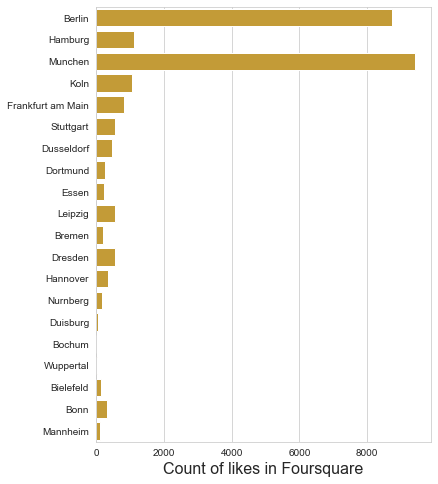

In [18]:
# Plot likes
plt.figure(figsize=(6,8)) 
ax=sns.barplot(y='city', x='likes_count', data=data_counts, color=color)
ax.set_ylabel('')
ax.set_xlabel('Count of likes in Foursquare', fontdict={'fontsize':16})

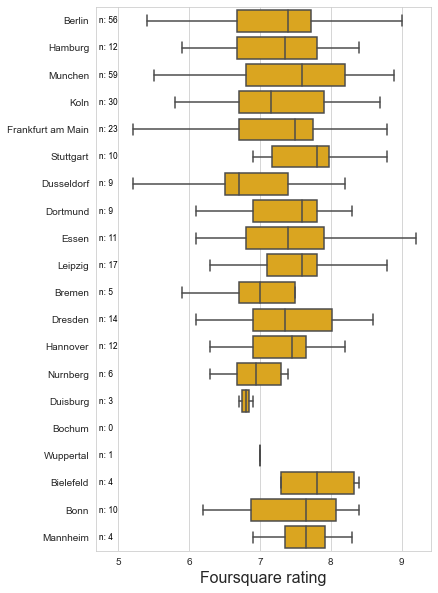

In [19]:
# Plot ratings
plt.figure(figsize=(6,10)) 
g = sns.boxplot(data=data, y='city', x='rating'
                 , order=data_counts['city']
                 , hue=None
                 , color='goldenrod'
                 , saturation=1.0
                 , fliersize=0.0
               )
g.axes.set_ylabel('')
g.axes.set_xlabel('Foursquare rating', fontdict={'fontsize':16})

# Calculate number of obs per group & median to position labels
medians = data.groupby(['city'], sort=False)['rating'].median().values
nobs = data_counts['ratings_count']
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]

# Add it to the plot
pos = range(len(nobs))
for tick, label in zip(pos, g.get_yticklabels()):
    g.text(x=4.72
           , y=pos[tick]
           , s=nobs[tick]
           , horizontalalignment='left'
           , verticalalignment='center'
           , size='small'
           , color='black'
           , weight='normal')



# Does population structure explain density of biergartens?

In [20]:
# Create modeling dataset
X_cols = [
        'latitude', 
        'longitude',
        'Proportion of population aged 0-4 years',
        'Proportion of population aged 5-9 years',
        'Proportion of population aged 10-14 years',
        'Proportion of population aged 15-19 years',
        'Proportion of population aged 20-24 years',
        'Proportion of population aged 25-34 years',
        'Proportion of population aged 35-44 years',
        'Proportion of population aged 45-54 years',
        'Proportion of total population aged 55-64',
        'Proportion of population aged 65-74 years',
        'Proportion of population aged 75 years and over',
        'Women per 100 men',
#         'Young-age dependency ratio (population aged 0-19 to population 20-64 years)',
        'Nationals as a proportion of population']
city_df = pd.DataFrame(data['city'])
X = data[X_cols].drop_duplicates().reset_index(drop=True)
# X.rename(columns={'Proportion of total population aged 55-64':'Proportion of population aged 55-64 years'}, inplace=True)

# Create target variable
y = data_counts['biergarten_count_100k']

In [21]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
X.drop(X[to_drop], axis=1, inplace=True)

In [22]:
# Pipeline for linear regression
lin_reg_pipe = Pipeline([('minmax', MinMaxScaler(feature_range=(-1,1)))
                ,('lin_reg', LinearRegression(fit_intercept=True))])

# Train the regression model
lin_reg_pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(-1, 1))),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

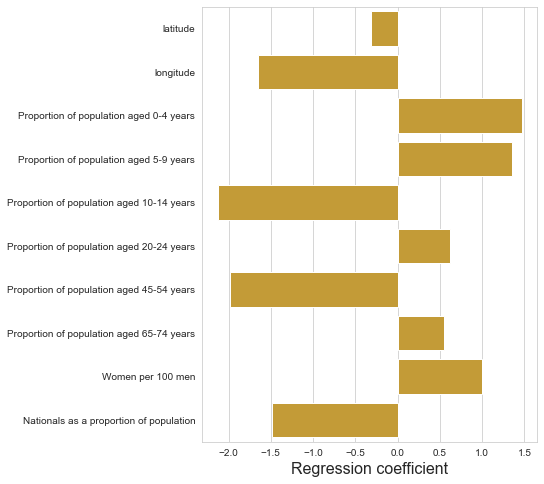

Intercept: 2.7320729294992088
R^2: 0.8749999344708379


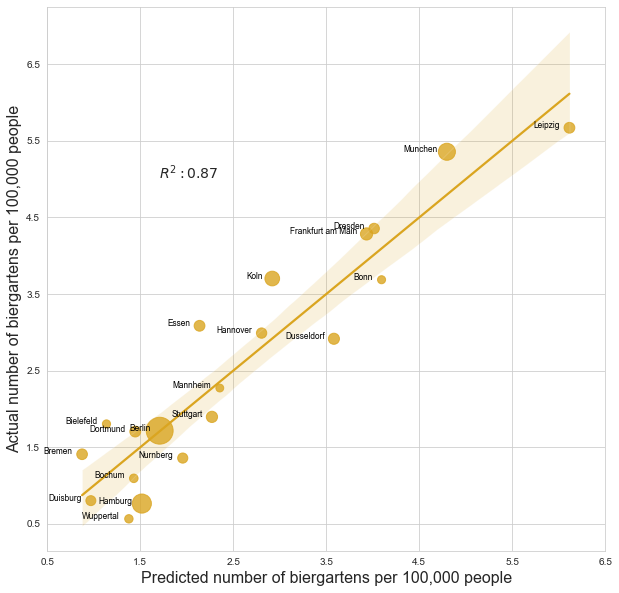

In [23]:
# Plot regression coeffiecient
plt.figure(figsize=(6,8)) 
barplot_data = pd.concat([pd.Series(X.columns.to_list()), pd.Series(lin_reg_pipe['lin_reg'].coef_)], axis=1)
barplot_data.columns = ['variable', 'coef']
ax=sns.barplot(y='variable', x='coef', data=barplot_data, color=color)
ax.axes.set_ylabel('')
ax.axes.set_xlabel('Regression coefficient', fontdict={'fontsize':16})
plt.show()

# Print regression measures
print('Intercept: {}'.format(lin_reg_pipe['lin_reg'].intercept_))
print('R^2: {}'.format(lin_reg_pipe.score(X,y)))

# Plot predictions and actuals
slope, intercept, r_value, p_value, std_err = stats.linregress(lin_reg_pipe.predict(X),y)
plt.figure(figsize=(10,10)) 
g = sns.regplot(lin_reg_pipe.predict(X), y, color=color
                , scatter_kws={'s':data_counts['total_population']/5000})
g.axes.set_xlabel('Predicted number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.axes.set_ylabel('Actual number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.text(1.7, 5, r'$R^2:{0:.2f}$'.format(r_value**2), fontdict={'fontsize':14})
g.set_xticks(np.arange(0.5,7,1))
g.set_yticks(np.arange(0.5,7,1))

for line in range(0, data_counts.shape[0]):
    g.text(x=lin_reg_pipe.predict(X)[line]-0.1
            , y=y[line]
            , s=data_counts.city[line]
            , horizontalalignment='right'
            , verticalalignment='baseline'
            , size='small'
            , color='black')
    
plt.show()

# Does local living standard explain biergarten density in region?

In [24]:
# Create modeling dataset
X_cols = [
        'latitude',
        'longitude',
        'Activity rate',
        'Employment (jobs) in agriculture, fishery (NACE Rev. 2, A)',
        'Employment (jobs) in arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies (NACE Rev. 2, R to U)',
        'Employment (jobs) in construction (NACE Rev. 2, F)',
        'Employment (jobs) in financial and insurance activities (NACE Rev. 2, K)',
        'Employment (jobs) in information and communication (NACE Rev. 2, J)',
        'Employment (jobs) in mining, manufacturing, energy (NACE Rev. 2, B-E)',
        'Employment (jobs) in professional, scientific and technical activities; administrative and support service activities (NACE Rev. 2, M and N)',
        'Employment (jobs) in public administration, defence, education, human health and social work activities (NACE Rev. 2, O to Q)',
        'Employment (jobs) in real estate activities (NACE Rev. 2, L)',
        'Employment (jobs) in trade, transport, hotels, restaurants (NACE Rev. 2, G to I)',
        'Proportion of employment in industries (NACE Rev.1.1 C-E)',
        'Unemployment rate, female', 
        'Unemployment rate, male']
city_df = pd.DataFrame(data['city'])
X = data[X_cols].drop_duplicates().reset_index(drop=True)
X.rename(columns={'Employment (jobs) in agriculture, fishery (NACE Rev. 2, A)':'Jobs in agriculture, fishery',
        'Employment (jobs) in arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies (NACE Rev. 2, R to U)': 'Jobs in arts, entertainment and recreation; other service',
        'Employment (jobs) in construction (NACE Rev. 2, F)':'Jobs in construction',
        'Employment (jobs) in financial and insurance activities (NACE Rev. 2, K)':'Jobs in financial and insurance activities',
        'Employment (jobs) in information and communication (NACE Rev. 2, J)':'Jobs in information and communication',
        'Employment (jobs) in mining, manufacturing, energy (NACE Rev. 2, B-E)':'Jobs in mining, manufacturing, energy',
        'Employment (jobs) in professional, scientific and technical activities; administrative and support service activities (NACE Rev. 2, M and N)':'Jobs in professional, scientific and technical; administrative and support service',
        'Employment (jobs) in public administration, defence, education, human health and social work activities (NACE Rev. 2, O to Q)':'Jobs in public administration, defence, education, human health and social work',
        'Employment (jobs) in real estate activities (NACE Rev. 2, L)':'Jobs in real estate',
        'Employment (jobs) in trade, transport, hotels, restaurants (NACE Rev. 2, G to I)':'Jobs in trade, transport, hotels, restaurants',
        'Proportion of employment in industries (NACE Rev.1.1 C-E)':'Proportion of employment in industries'}
         , inplace=True)

# Create target variable
y = data_counts['biergarten_count_100k']

In [25]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
X.drop(X[to_drop], axis=1, inplace=True)

In [26]:
# Pipeline for linear regression
lin_reg_pipe = Pipeline([('minmax', MinMaxScaler(feature_range=(-1,1)))
                ,('lin_reg', LinearRegression(fit_intercept=True))])

# Train the regression model
lin_reg_pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(-1, 1))),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

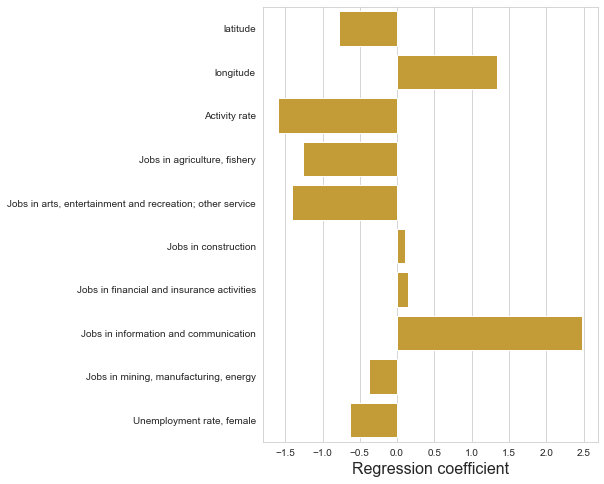

Intercept: 1.3367832384021552
R^2: 0.6975540884485455


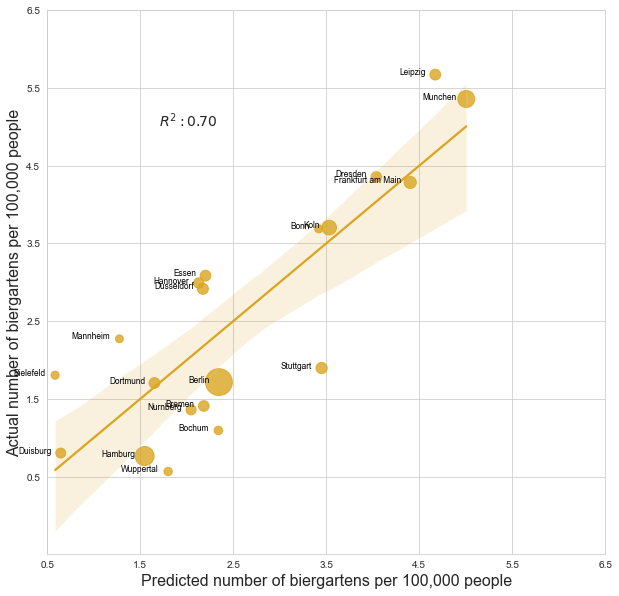

In [27]:
# Plot regression coeffiecient
plt.figure(figsize=(6,8)) 
barplot_data = pd.concat([pd.Series(X.columns.to_list()), pd.Series(lin_reg_pipe['lin_reg'].coef_)], axis=1)
barplot_data.columns = ['variable', 'coef']
ax=sns.barplot(y='variable', x='coef', data=barplot_data, color=color)
ax.axes.set_ylabel('')
ax.axes.set_xlabel('Regression coefficient', fontdict={'fontsize':16})
plt.show()

# Print regression measures
print('Intercept: {}'.format(lin_reg_pipe['lin_reg'].intercept_))
print('R^2: {}'.format(lin_reg_pipe.score(X,y)))

# Plot predictions and actuals
slope, intercept, r_value, p_value, std_err = stats.linregress(lin_reg_pipe.predict(X),y)
plt.figure(figsize=(10,10)) 
g = sns.regplot(lin_reg_pipe.predict(X), y, color=color
                , scatter_kws={'s':data_counts['total_population']/5000})
g.axes.set_xlabel('Predicted number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.axes.set_ylabel('Actual number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.text(1.7, 5, r'$R^2:{0:.2f}$'.format(r_value**2), fontdict={'fontsize':14})
g.set_xticks(np.arange(0.5,7,1))
g.set_yticks(np.arange(0.5,7,1))

for line in range(0, data_counts.shape[0]):
    g.text(x=lin_reg_pipe.predict(X)[line]-0.1
            , y=y[line]
            , s=data_counts.city[line]
            , horizontalalignment='right'
            , verticalalignment='baseline'
            , size='small'
            , color='black')
    
plt.show()

In [28]:
# Create modeling dataset
X_cols = [
        'latitude',
        'longitude',
        'Proportion of population aged 0-4 years',
        'Proportion of population aged 5-9 years',
        'Proportion of population aged 10-14 years',
        'Proportion of population aged 15-19 years',
        'Proportion of population aged 20-24 years',
        'Proportion of population aged 25-34 years',
        'Proportion of population aged 35-44 years',
        'Proportion of population aged 45-54 years',
        'Proportion of total population aged 55-64',
        'Proportion of population aged 65-74 years',
        'Proportion of population aged 75 years and over',
        'Women per 100 men',
        'Young-age dependency ratio (population aged 0-19 to population 20-64 years)',
        'Nationals as a proportion of population',
        'Activity rate',
        'Employment (jobs) in agriculture, fishery (NACE Rev. 2, A)',
        'Employment (jobs) in arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies (NACE Rev. 2, R to U)',
        'Employment (jobs) in construction (NACE Rev. 2, F)',
        'Employment (jobs) in financial and insurance activities (NACE Rev. 2, K)',
        'Employment (jobs) in information and communication (NACE Rev. 2, J)',
        'Employment (jobs) in mining, manufacturing, energy (NACE Rev. 2, B-E)',
        'Employment (jobs) in professional, scientific and technical activities; administrative and support service activities (NACE Rev. 2, M and N)',
        'Employment (jobs) in public administration, defence, education, human health and social work activities (NACE Rev. 2, O to Q)',
        'Employment (jobs) in real estate activities (NACE Rev. 2, L)',
        'Employment (jobs) in trade, transport, hotels, restaurants (NACE Rev. 2, G to I)',
        'Proportion of employment in industries (NACE Rev.1.1 C-E)',
        'Unemployment rate, female', 
        'Unemployment rate, male']
city_df = pd.DataFrame(data['city'])
X = data[X_cols].drop_duplicates().reset_index(drop=True)
X.rename(columns={'Proportion of total population aged 55-64':'Proportion of population aged 55-64 years','Employment (jobs) in agriculture, fishery (NACE Rev. 2, A)':'Jobs in agriculture, fishery',
        'Employment (jobs) in arts, entertainment and recreation; other service activities; activities of household and extra-territorial organizations and bodies (NACE Rev. 2, R to U)': 'Jobs in arts, entertainment and recreation; other service',
        'Employment (jobs) in construction (NACE Rev. 2, F)':'Jobs in construction',
        'Employment (jobs) in financial and insurance activities (NACE Rev. 2, K)':'Jobs in financial and insurance activities',
        'Employment (jobs) in information and communication (NACE Rev. 2, J)':'Jobs in information and communication',
        'Employment (jobs) in mining, manufacturing, energy (NACE Rev. 2, B-E)':'Jobs in mining, manufacturing, energy',
        'Employment (jobs) in professional, scientific and technical activities; administrative and support service activities (NACE Rev. 2, M and N)':'Jobs in professional, scientific and technical; administrative and support service',
        'Employment (jobs) in public administration, defence, education, human health and social work activities (NACE Rev. 2, O to Q)':'Jobs in public administration, defence, education, human health and social work',
        'Employment (jobs) in real estate activities (NACE Rev. 2, L)':'Jobs in real estate',
        'Employment (jobs) in trade, transport, hotels, restaurants (NACE Rev. 2, G to I)':'Jobs in trade, transport, hotels, restaurants',
        'Proportion of employment in industries (NACE Rev.1.1 C-E)':'Proportion of employment in industries'}, inplace=True)

# Create target variable
y = data_counts['biergarten_count_100k']

In [29]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
X.drop(X[to_drop], axis=1, inplace=True)

In [30]:
# Pipeline for linear regression
lin_reg_pipe = Pipeline([
                ('minmax', MinMaxScaler(feature_range=(-1,1))),
                ('lin_reg', LinearRegression(fit_intercept=True))])

# Train the regression model
lin_reg_pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('minmax', MinMaxScaler(copy=True, feature_range=(-1, 1))),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

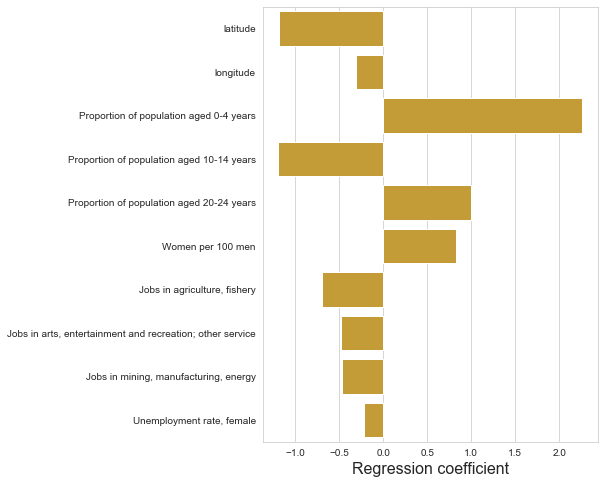

In [ ]:
# Plot regression coeffiecient
plt.figure(figsize=(6,8)) 
barplot_data = pd.concat([pd.Series(X.columns.to_list()), pd.Series(lin_reg_pipe['lin_reg'].coef_)], axis=1)
barplot_data.columns = ['variable', 'coef']
ax=sns.barplot(y='variable', x='coef', data=barplot_data, color=color)
ax.axes.set_ylabel('')
ax.axes.set_xlabel('Regression coefficient', fontdict={'fontsize':16})
plt.show()

# Print regression measures
print('Intercept: {}'.format(lin_reg_pipe['lin_reg'].intercept_))
print('R^2: {}'.format(lin_reg_pipe.score(X,y)))

# Plot predictions and actuals
slope, intercept, r_value, p_value, std_err = stats.linregress(lin_reg_pipe.predict(X),y)
plt.figure(figsize=(10,10)) 
g = sns.regplot(lin_reg_pipe.predict(X), y, color=color
                , scatter_kws={'s':data_counts['total_population']/5000})
g.axes.set_xlabel('Predicted number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.axes.set_ylabel('Actual number of biergartens per 100,000 people', fontdict={'fontsize':16})
g.text(1.7, 5, r'$R^2:{0:.2f}$'.format(r_value**2), fontdict={'fontsize':14})
g.set_xticks(np.arange(0.5,7,1))
g.set_yticks(np.arange(0.5,7,1))

for line in range(0, data_counts.shape[0]):
    g.text(x=lin_reg_pipe.predict(X)[line]-0.1
            , y=y[line]
            , s=data_counts.city[line]
            , horizontalalignment='right'
            , verticalalignment='baseline'
            , size='small'
            , color='black')
    
plt.show()